In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.models import AlexNet
from tqdm import tqdm
import os
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class CustomDataset:
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.classes = os.listdir(os.path.join(root_dir, split))

        self.data = self._load_data()

    def _load_data(self):
        data = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, self.split, class_name)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                data.append((file_path, self.classes.index(class_name)))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomMnistDataset(Dataset):
    def __init__(self, root, train=True, download=True, transform=None, classes=[]):
        self.mnist_dataset = MNIST(root=root, train=train, download=download, transform=transform)
        self.classes = classes
        self.indices = [i for i in range(len(self.mnist_dataset)) if self.mnist_dataset.targets[i] in classes]

    def __getitem__(self, index):
        img, target = self.mnist_dataset[self.indices[index]]
        return img, target

    def __len__(self):
        return len(self.indices)

In [ ]:
# Set the seed for reproducibility
torch.manual_seed(42)

In [7]:
#RESNET18 and 50
import torchvision.models as models
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

In [ ]:
#RESNET18 and 50
import torchvision.models as models
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [9]:
# Load MNIST dataset for classes 0 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset_class_0 = CustomMnistDataset(root='./data', train=True, download=True, transform=transform, classes=[0])
mnist_dataset_class_1 = CustomMnistDataset(root='./data', train=True, download=True, transform=transform, classes=[1])

mnist_dataset_test_class_0 = CustomMnistDataset(root='./data', train=False, download=True, transform=transform, classes=[0])
mnist_dataset_test_class_1 = CustomMnistDataset(root='./data', train=False, download=True, transform=transform, classes=[1])
# Create DataLoader for each class
class_0_loader = DataLoader(mnist_dataset_class_0, batch_size=64, shuffle=True)
class_0_test_loader = DataLoader(mnist_dataset_test_class_0, batch_size=64, shuffle=True)
class_1_loader = DataLoader(mnist_dataset_class_1, batch_size=64, shuffle=True)
class_1_test_loader = DataLoader(mnist_dataset_test_class_1, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 135183144.40it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 70061130.03it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 49083337.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6562359.20it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset_location = "/content/drive/MyDrive/DB/Malware/BigFolder/FinalDB/M2"
dataset = CustomDataset(root_dir=dataset_location, split='train', transform=transform)
train_dataset = CustomDataset(root_dir=dataset_location, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = CustomDataset(root_dir=dataset_location, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#test_dataset = CustomDataset(root_dir=dataset_location, split='test', transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [24]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [25]:
#model_class_T1 = AlexNet(num_classes=7).to(device)
model_class_T1 = ResNet50(num_classes=7).to(device)
#RESNET18 and 50


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

# Train the first class
#criterion = nn.CrossEntropyLoss()
#optimizer_class_T1 = optim.SGD(model_class_T1.parameters(), lr=0.001, momentum=0.9)

#for epoch in range(1):  # Adjust the number of epochs as needed
#    for inputs, labels in tqdm(train_loader, desc="Training", unit="batch"):
#        inputs, labels = inputs.to(device), labels.to(device)
#        #inputs, labels = inputs, labels
#        print(labels)
#        optimizer_class_T1.zero_grad()
#        outputs = model_class_T1(inputs)
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer_class_T1.step()

In [26]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score
model1 = torch.load("/content/drive/MyDrive/DB/Malware/BigFolder/FinalDB/Resnet18/model_class_M2_resnet50_10.pth",map_location=torch.device('cpu'))
model_path='/content/drive/MyDrive/DB/Malware/BigFolder/FinalDB/Resnet18/model_class_M2_resnet50_10.pth'
predictions = []
true_labels = []

# Assuming 'model' is your loaded model and 'test_loader' is your DataLoader
model_class_T1 = ResNet50(7)  # Replace with your model class
model_class_T1.load_state_dict(model1)
 # Set the model to evaluation mode
model_class_T1.eval()  # Set the model to evaluation mode
model_class_T1.to(device)  # Move model to the configured device

# Iterate through the test dataset
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    true_labels.extend(labels.cpu().numpy())

    # Generate predictions for the current batch
    batch_predictions = torch.argmax(model_class_T1(images), dim=1).cpu().numpy()
    predictions.extend(batch_predictions)

# Calculate and print the accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 73.43%


In [27]:
# Calculate and print the accuracy
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predictions,average='weighted')
print(f"Model f1_score: {f1 * 100:.2f}%")

Model f1_score: 73.36%


In [28]:
# Calculate and print the accuracy
from sklearn.metrics import precision_score
precision = precision_score(true_labels, predictions, average='micro')
print(f"Model precision: {precision * 100:.2f}%")

Model precision: 73.43%


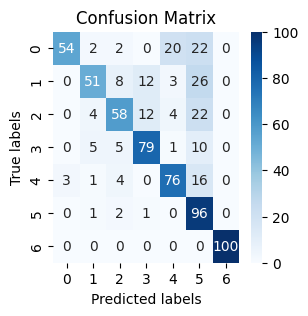

Accuracy: 73.43%


In [29]:
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(true_labels, predictions)

# Print the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


# Calculate and print other evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
torch.save(model_class_T1.state_dict(), '/content/drive/MyDrive/DB/Malware/BigFolder/model_class_T1.pth')